# 3 Style Transfer

## 3.1

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def content_loss(target_features, generated_features):
    return torch.nn.functional.mse_loss(generated_features, target_features)

def gram_matrix(features):
    B, C, H, W = features.size()
    features = features.view(C, H * W)
    gram = torch.mm(features, features.t())
    return gram / (C * H * W)

def style_loss(style_features, generated_features):
    style_gram = gram_matrix(style_features)
    generated_gram = gram_matrix(generated_features)
    return torch.nn.functional.mse_loss(generated_gram, style_gram)


## 3.2

Using device: mps
Starting optimization using LBFGS on MPS...
Iteration 50: Total Loss = 480.03228759765625
Iteration 100: Total Loss = 193.6273956298828
Iteration 150: Total Loss = 92.24302673339844
Iteration 200: Total Loss = 47.776573181152344


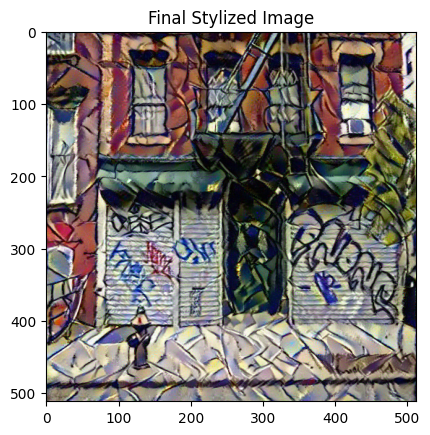

Style transfer complete! Image saved as 'output_result.jpg'.


In [54]:
# Check for MPS support on Mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define image size and transformation pipeline
imsize = 512 if torch.backends.mps.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def load_image(image_path):
    """Load an image and transform it into a tensor."""
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Convert tensor to PIL image for display
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

# Function to extract features from VGG19
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content feature layer
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Load VGG19 model (Fixed Loading)
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze model parameters
for param in vgg.parameters():
    param.requires_grad = False

# Load content and style images
content_img = load_image("content/building.jpg")  
style_img = load_image("styles/the-exit-of-the-russian-ballet.jpg")   

# Extract features
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

# Compute style Gram matrices
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initialize generated image from content image
generated_img = content_img.clone().requires_grad_(True)

# Loss weights
content_weight = 1
style_weight = 1e8

# Optimizer
optimizer = optim.LBFGS([generated_img], lr=0.1)

print("Starting optimization using LBFGS on MPS...")
run = [0]

# Define closure function for LBFGS
def closure():
    optimizer.zero_grad()

    gen_features = get_features(generated_img, vgg)

    # Compute content loss using the provided function
    content_loss_value = content_loss(content_features['conv4_2'], gen_features['conv4_2'])

    # Compute style loss using the provided function
    style_loss_value = 0
    for layer in style_grams:
        style_loss_value += style_loss(style_features[layer], gen_features[layer])

    # Total loss
    total_loss = content_weight * content_loss_value + style_weight * style_loss_value
    total_loss.backward()

    run[0] += 1
    if run[0] % 50 == 0:
        print(f"Iteration {run[0]}: Total Loss = {total_loss.item()}")

    # Clamp values to valid range [0,1]
    with torch.no_grad():
        generated_img.clamp_(0, 1)

    return total_loss

# Run optimization
num_steps = 12

for step in range(num_steps):
    optimizer.step(closure)

# Display final result
imshow(generated_img, title="Final Stylized Image")

# Save output
final_image = generated_img.cpu().clone().squeeze(0)
final_image = unloader(final_image)
final_image.save("output_result.jpg")

print("Style transfer complete! Image saved as 'output_result.jpg'.")


### 5 configurations of content_weight and style_weight:

content image: building.jpg  

style image: the-exit-of-the-russian-ballet.jpg

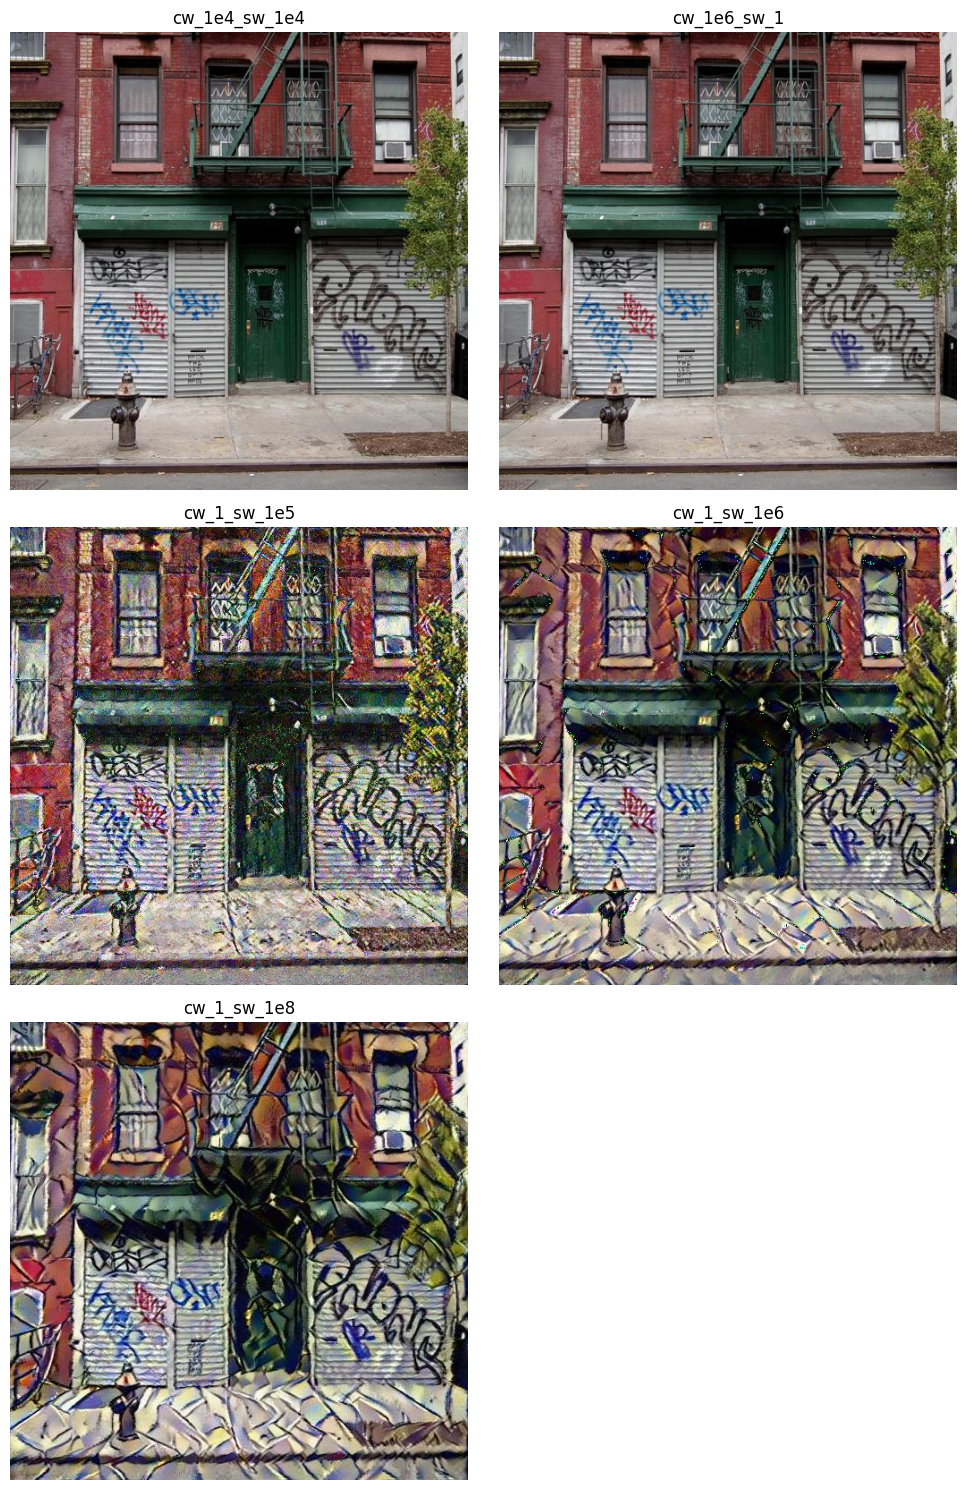

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = np.array(axes).flatten() 

img = Image.open("cw_1e4_sw_1e4.jpg").convert('RGB')

axes[0].imshow(img)
axes[0].set_title("cw_1e4_sw_1e4")
axes[0].axis('off')

img = Image.open("cw_1e6_sw_1.jpg").convert('RGB')

axes[1].imshow(img)
axes[1].set_title("cw_1e6_sw_1")
axes[1].axis('off')

img = Image.open("cw_1_sw_1e5.jpg").convert('RGB')

axes[2].imshow(img)
axes[2].set_title("cw_1_sw_1e5")
axes[2].axis('off')

img = Image.open("cw_1_sw_1e6.jpg").convert('RGB')

axes[3].imshow(img)
axes[3].set_title("cw_1_sw_1e6")
axes[3].axis('off')

img = Image.open("cw_1_sw_1e8.jpg").convert('RGB')

axes[4].imshow(img)
axes[4].set_title("cw_1_sw_1e8")
axes[4].axis('off')
axes[5].axis('off')



plt.tight_layout()



Starting optimization with Adam...
Adam Step 0: Total Loss = 2557.8408203125
Adam Step 100: Total Loss = 62.280635833740234
Adam Step 200: Total Loss = 34.52936553955078
Adam Step 300: Total Loss = 25.772951126098633
Adam Step 400: Total Loss = 21.476150512695312


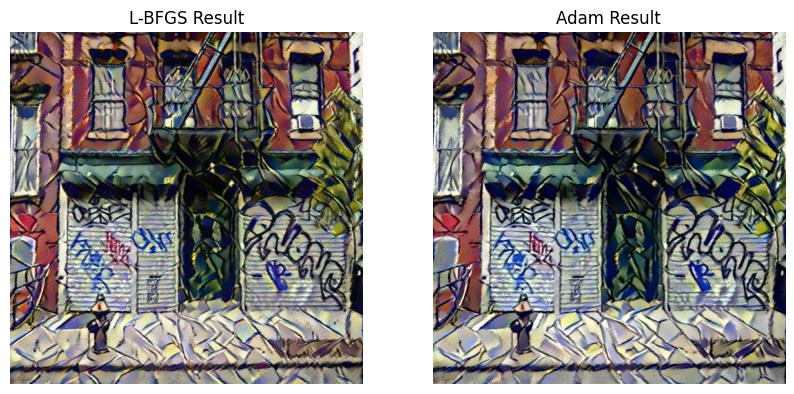

In [44]:

# Define the Adam optimizer function
def optimize_with_adam(generated_img, content_features, style_features, style_grams, vgg, content_weight=1, style_weight=1e8, num_steps=500, lr=0.01):
    optimizer = optim.Adam([generated_img], lr=lr)
    loss_history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        
        gen_features = get_features(generated_img, vgg)

        # Compute losses
        content_loss_value = content_loss(content_features['conv4_2'], gen_features['conv4_2'])
        style_loss_value = sum(style_loss(style_features[layer], gen_features[layer]) for layer in style_grams)

        total_loss = content_weight * content_loss_value + style_weight * style_loss_value
        total_loss.backward()

        optimizer.step()

        # Clamp values to valid range [0,1]
        with torch.no_grad():
            generated_img.clamp_(0, 1)

        loss_history.append(total_loss.item())

        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"Adam Step {step}: Total Loss = {total_loss.item()}")

    return generated_img, loss_history

# Reload content image for a fresh start with Adam
adam_generated_img = content_img.clone().requires_grad_(True)

# Run Adam optimization
print("\nStarting optimization with Adam...")
adam_result, adam_loss_history = optimize_with_adam(adam_generated_img, content_features, style_features, style_grams, vgg)

# Display both results side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Convert tensors to images
lbfgs_result = generated_img.cpu().clone().squeeze(0)
lbfgs_result = unloader(lbfgs_result)

adam_result = adam_result.cpu().clone().squeeze(0)
adam_result = unloader(adam_result)

# Show L-BFGS result
axes[0].imshow(lbfgs_result)
axes[0].set_title("L-BFGS Result")
axes[0].axis("off")

# Show Adam result
axes[1].imshow(adam_result)
axes[1].set_title("Adam Result")
axes[1].axis("off")

plt.show()

# Save images
lbfgs_result.save("output_lbfgs.jpg")
adam_result.save("output_adam.jpg")




### Comparison between Adam and L-BFGS:

Both have almost similar results. Even the time taken to run both is similar. L-BFGS is slightly quicker. May be differences can be observed for different pair of content-style image but for this one it's almost identical.

(-0.5, 511.5, 511.5, -0.5)

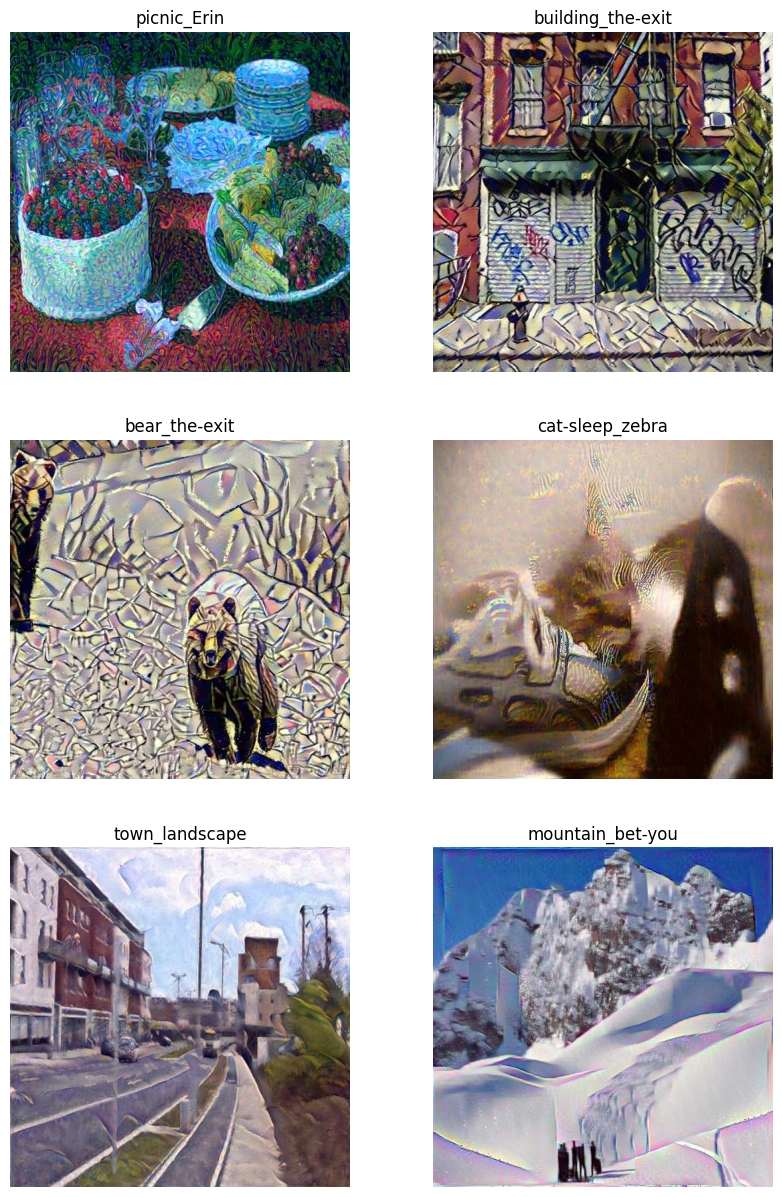

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = np.array(axes).flatten() 

img = Image.open("output_result2_picnic_Erin.jpg").convert('RGB')

axes[0].imshow(img)
axes[0].set_title("picnic_Erin")
axes[0].axis('off')

img = Image.open("output_result3_building_the_exit.jpg").convert('RGB')

axes[1].imshow(img)
axes[1].set_title("building_the-exit")
axes[1].axis('off')

img = Image.open("output_result4_bear_the_exit.jpg").convert('RGB')

axes[2].imshow(img)
axes[2].set_title("bear_the-exit")
axes[2].axis('off')

img = Image.open("output_result5_cat_sleep_zebra.jpg").convert('RGB')

axes[3].imshow(img)
axes[3].set_title("cat-sleep_zebra")
axes[3].axis('off')

img = Image.open("output_result6_town_landscape.jpg").convert('RGB')

axes[4].imshow(img)
axes[4].set_title("town_landscape")
axes[4].axis('off')

img = Image.open("output_result7_mountain_bet-you.jpg").convert('RGB')

axes[5].imshow(img)
axes[5].set_title("mountain_bet-you")
axes[5].axis('off')

### Observations about quality and what domains work:

From above various combinations of content and style we can judge the quality and figure out what domains work.
First of all we can observe that quality of output is good where style is more about texture,edges and not about colors. So, the domains for which style transfer works better is where we have to copy the texture,edges like style. For example the style "the-exit-of-the-russian-ballet" works on various images. It worked on building as well as bear both tese content images are of very different domains one is wild/nature(bear) and other is manmade things(building) still the style works on both because the style has mainly cartoon/animation effect along with mozaic effect which better learned by our model. But let's take example of cat sleeping content image and zebra style this one didn't work because the main thing in zebra style is the yellow tinge of image it doesn't have an effect through outlines/edges/texture. Another similar failure example is mountains content and style is bet-you. Again the example where picnic is content and Erin is style works very well because style's mainly is about. Also in this example the vibrant colors of style are learned to an good extent.  

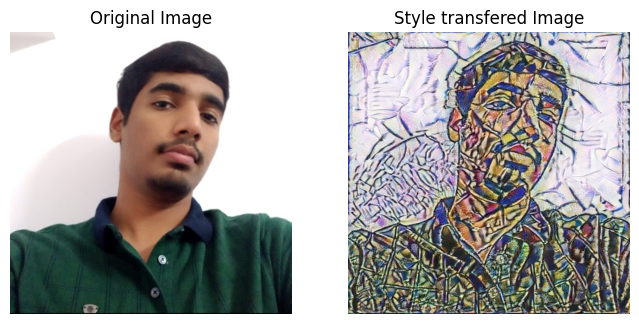

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

img = Image.open("Aditya_DP.jpg").convert('RGB')

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

img = Image.open("Aditya_DP2.jpg").convert('RGB')

axes[1].imshow(img)
axes[1].set_title("Style transfered Image")
axes[1].axis("off")

plt.show()